In [1]:
import os
import json
import torch
from PIL import Image
import matplotlib.pyplot as plt

from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.utils import disable_torch_init
from llava.mm_utils import process_images, tokenizer_image_token, KeywordsStoppingCriteria

/home/anurag/anaconda3/envs/llava/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_dir = "/mnt/drive-d/anurag/roadwork/"
scene_data_dir = os.path.join(base_dir, "scene")

In [3]:
disable_torch_init()

val_data = os.path.join(scene_data_dir, "annotations", "instances_val_gps_split.json")
with open(val_data, "r") as f:
    val_data = json.load(f)

image_info = val_data["images"][10]

image_path = os.path.join(scene_data_dir, "images", image_info["file_name"])
gt_desc = image_info["scene_description"]

In [4]:
def load_image_from_path(image_path, image_processor, model, device):
    image = Image.open(image_path).convert('RGB')
    image_tensor = process_images([image], image_processor, None).to(device)

    if type(image_tensor) is list:
        image_tensor = [image.to(model.device, dtype=torch.float16) for image in image_tensor]
    else:
        image_tensor = image_tensor.to(model.device, dtype=torch.float16)
    return image_tensor

def generate_prompt(inp, conv, model):
    # first message
    if model.config.mm_use_im_start_end:
        inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + inp
    else:
        inp = DEFAULT_IMAGE_TOKEN + '\n' + inp
    conv.append_message(conv.roles[0], inp)

    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()
    return prompt

def get_stopping_criteria(conv, input_ids, tokenizer):
    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    keywords = [stop_str]
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)
    return stopping_criteria


def generate_caption(model, input_ids, image_tensor, stopping_criteria, temperature=0.2, max_new_tokens=2048):
    with torch.inference_mode():
        return model.generate(
            input_ids,
            images=image_tensor,
            do_sample=True,
            temperature=temperature,
            max_new_tokens=max_new_tokens,
            # streamer=streamer,
            use_cache=True,
            stopping_criteria=[stopping_criteria])


## Generate Descriptions without Context

In [5]:
model_path = "./models/llava_scene_description/llava_lora/captions-workzone-llava-v1.5-7b-lora/"
model_base = "./models/llava_scene_description/llava-v1.5-7b/"
device = "cuda:0"

model_name = get_model_name_from_path(model_path)
print("Model Name: ", model_name)
tokenizer, model, image_processor, context_len = load_pretrained_model(model_path, model_base, model_name, device_map=device)

Model Name:  captions-workzone-llava-v1.5-7b-lora
Loading LLaVA from base model...


/home/anurag/anaconda3/envs/llava/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 2/2 [00:08<00:00,  4.04s/it]


Loading additional LLaVA weights...
Loading LoRA weights...
Merging LoRA weights...
Model is loaded...


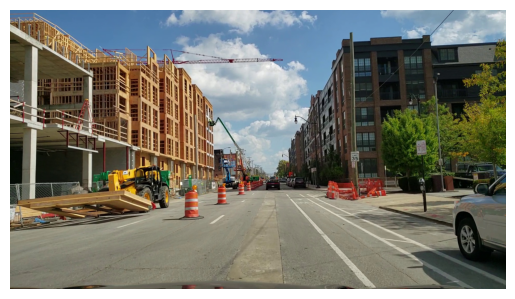

GT:  Sidewalk work on right side of road. Tubular marker, drum, and fences fully blocking right sidewalk. Building work on left side of work. Line of drums in front of building partially blocking road. Work vehicles in work zone. Fence along sidewalk in front of building.
Generated:  Drums and barriers on left side of road. Work vehicles on left side of road.</s>


In [6]:
conv_mode = "llava_v1"
temperature = 0.2
max_new_tokens = 2048

inp = "You are the planner of an autonomous vehicle, ONLY describe the workzone in the scene identifying and describing the spatial relationship of relevant objects to plan and navigate a route."

image_tensor = load_image_from_path(image_path, image_processor, model, device)

conv = conv_templates[conv_mode].copy()
roles = conv.roles
prompt = generate_prompt(inp, conv, model)

input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()
stopping_criteria = get_stopping_criteria(conv, input_ids, tokenizer)

output_ids = generate_caption(model, input_ids, image_tensor, stopping_criteria, temperature=temperature, max_new_tokens=max_new_tokens)
outputs = tokenizer.decode(output_ids[0, input_ids.shape[1]:]).strip()

img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

print("GT: ", gt_desc)
print("Generated: ", outputs)

## Generate Descriptions with Ground Truth Context

In [5]:
model_path = "./models/llava_scene_description/llava_lora/captions-with-context-workzone-llava-v1.5-7b-lora"
model_base = "./models/llava_scene_description/llava-v1.5-7b/"
device = "cuda:0"

model_name = get_model_name_from_path(model_path)
print("Model Name: ", model_name)
tokenizer, model, image_processor, context_len = load_pretrained_model(model_path, model_base, model_name, device_map=device)

Model Name:  captions-with-context-workzone-llava-v1.5-7b-lora
Loading LLaVA from base model...


/home/anurag/anaconda3/envs/llava/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 2/2 [00:08<00:00,  4.05s/it]


Loading additional LLaVA weights...
Loading LoRA weights...
Merging LoRA weights...
Model is loaded...


Input Prompt:  A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: <image>
You are the planner of an autonomous vehicle, ONLY describe the workzone in the scene identifying and describing the spatial relationship of relevant objects to plan and navigate a route. Known workzone objects in `(object: confidence) at [(x1, y1), (x2, y2)]` normalized format: 
Work Vehicle: 1.0 at [[(0.2, 0.56), (0.32, 0.71)]],
Tubular Marker: 1.0 at [[(0.71, 0.66), (0.73, 0.68)]],
Drum: 1.0 at [[(0.46, 0.62), (0.48, 0.66)]],
Tubular Marker: 1.0 at [[(0.64, 0.61), (0.65, 0.65)]],
Tubular Marker: 1.0 at [[(0.74, 0.61), (0.75, 0.65)]],
Work Vehicle: 1.0 at [[(0.42, 0.53), (0.46, 0.64)]],
Drum: 1.0 at [[(0.49, 0.61), (0.51, 0.64)]],
Tubular Marker: 1.0 at [[(0.72, 0.6), (0.73, 0.65)]],
Drum: 1.0 at [[(0.73, 0.64), (0.76, 0.67)]],
Tubular Marker: 1.0 at [[(0.64, 0.61), (0.64, 0.65)]],
Drum: 1.0 at [[(0.3

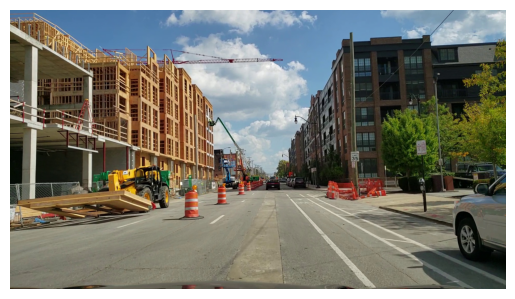

GT:  Sidewalk work on right side of road. Tubular marker, drum, and fences fully blocking right sidewalk. Building work on left side of work. Line of drums in front of building partially blocking road. Work vehicles in work zone. Fence along sidewalk in front of building.
Generated:  Tubular markers and drums on right side of road. Work vehicles on left side of road.</s>


In [6]:
def get_objects_from_anns_image_info(image_info, anns):
    image_id = image_info["id"]
    objects = []
    for ann in anns:
        if ann["image_id"] == image_id:
            objects.append(ann)
    return objects

def generate_objects_string(image_info, objects, categories):
    W, H = image_info["width"], image_info["height"]
    cat_names = {
        x["id"]: x["name"] for x in categories
    }
    objects_str = ""
    for obj in objects:
        category_id = obj["category_id"]
        x, y, w, h = obj["bbox"]
        x1, y1, x2, y2 = x, y, x + w, y + h
        x1, y1, x2, y2 = x1/W, y1/H, x2/W, y2/H
        x1, y1, x2, y2 = round(x1, 2), round(y1, 2), round(x2, 2), round(y2, 2)
        bbox = f"[({x1}, {y1}), ({x2}, {y2})]"
        confidence = 1.0
        cat_name = cat_names[category_id]        
        objects_str += f"{cat_name}: {confidence} at [{bbox}],\n"
    ## remove last comma
    objects_str = objects_str[:-2]
    return objects_str

conv_mode = "llava_v1"
temperature = 0.2
max_new_tokens = 2048

inp = "You are the planner of an autonomous vehicle, ONLY describe the workzone in the scene identifying and describing the spatial relationship of relevant objects to plan and navigate a route."

inp += " Known workzone objects in `(object: confidence) at [(x1, y1), (x2, y2)]` normalized format: \n"

objs = get_objects_from_anns_image_info(image_info, val_data["annotations"])
objects_str = generate_objects_string(image_info, objs, val_data["categories"])
inp += objects_str

image_tensor = load_image_from_path(image_path, image_processor, model, device)

conv = conv_templates[conv_mode].copy()
roles = conv.roles
prompt = generate_prompt(inp, conv, model)

input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()
stopping_criteria = get_stopping_criteria(conv, input_ids, tokenizer)

output_ids = generate_caption(model, input_ids, image_tensor, stopping_criteria, temperature=temperature, max_new_tokens=max_new_tokens)
outputs = tokenizer.decode(output_ids[0, input_ids.shape[1]:]).strip()

print("Input Prompt: ", prompt)
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

print("GT: ", gt_desc)
print("Generated: ", outputs)